In [19]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import os
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)


2.6.0


In [20]:
# Set parameter
nb_batch = 128
num_classes = 100
nb_epochs = 200


In [21]:
# Set save model info
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)


In [22]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar100.load_data('fine')
print('x_train shape:', x_train.shape)
print('x_train dtype:', x_train.dtype)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
x_train dtype: uint8
50000 train samples
10000 test samples


## Label class

y_test value : 0 ~ 99

In [23]:
print('Label class:\n', np.unique(y_test))
class_names = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly',
               'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup',
               'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard',
               'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom',
               'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum',
               'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
               'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper',
               'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle',
               'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']



Label class:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


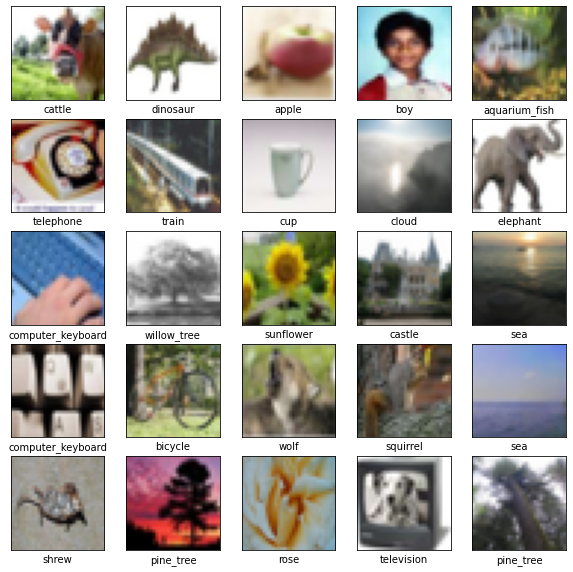

In [24]:
# 학습 이미지 확인
plt.figure(figsize=(10, 10), facecolor='white')
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train[i][0]])
plt.show()


In [25]:
# 전처리
AUTOTUNE = tf.data.AUTOTUNE

normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)
data_augmentation_layer = Sequential([
                            keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                            keras.layers.experimental.preprocessing.RandomRotation(0.05)
                        ])


def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets
    ds = ds.map(lambda x, y: (normalization_layer(x), y),
                num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Batch all datasets
    ds = ds.batch(nb_batch)

    # Use data augmentation only on the training set
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation_layer(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)

    # Use buffered prefecting on all datasets
    return ds.prefetch(buffer_size=AUTOTUNE)


In [26]:
# 전처리
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_ds = prepare(train_ds, shuffle=True, augment=True)
test_ds = prepare(test_ds)


In [27]:
def getModel(dropout_rate=0.0):
    model = Sequential()
    model.add(Conv2D(32, [3, 3], padding='same',
              activation='relu', input_shape=x_train.shape[1:]))
    model.add(keras.layers.BatchNormalization())
    model.add(Conv2D(32, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(Conv2D(32, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(MaxPooling2D([2, 2], strides=(2, 2), padding='same'))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(64, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(Conv2D(64, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(Conv2D(64, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(MaxPooling2D([2, 2], strides=(2, 2), padding='same'))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(128, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(Conv2D(128, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(Conv2D(128, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(MaxPooling2D([2, 2], strides=(2, 2), padding='same'))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(256, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(Conv2D(256, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(Conv2D(256, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(MaxPooling2D([2, 2], strides=(2, 2), padding='same'))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(512, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(Conv2D(512, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(Conv2D(512, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(MaxPooling2D([2, 2], strides=(2, 2), padding='same'))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(1024, [3, 3], padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(dropout_rate))

    # model.add(Dense(1024, activation='relu'))
    # model.add(Dropout(dropout_rate))

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))

    return model


In [28]:
def getModel2(dropout_rate=0.0):
    IMG_SIZE = 96
    
    base_model = keras.applications.ResNet50V2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                            weights='imagenet', 
                            include_top=False)
    base_model.trainable = False

    model = Sequential()
    model.add(keras.layers.Resizing(IMG_SIZE, IMG_SIZE, input_shape=x_train.shape[1:]))
    model.add(base_model)
    # model.add(keras.layers.AveragePooling2D((2 ,2), strides=(1, 1), padding='same'))
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(dropout_rate)),
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [29]:
# model = getModel(0.3)
model = getModel2(0.3)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 96, 96, 3)         0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 3, 3, 2048)        23564800  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              18875392  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               102500    
Total params: 42,542,692
Trainable params: 18,977,892
Non-trainable params: 23,564,800
_________________________________

In [30]:
# Compile
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])


In [31]:
# Restore weights
if os.path.isfile(model_path):
    # model.load_weights(model_path)
    # print('Weights load success.')
    pass

# Set callbacks
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=model_path, save_weights_only=True)

callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True,
                                         monitor='val_accuracy')

lr_reducer = keras.callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.1e-6)


In [32]:
hist = model.fit(train_ds, batch_size=nb_batch, epochs=nb_epochs,
                 verbose=1, validation_data=test_ds,
                 shuffle=True,
                 callbacks=[checkpointer, callback, lr_reducer])


Epoch 1/200
391/391 [==============================] - 26s 62ms/step - loss: 3.0062 - accuracy: 0.3071 - val_loss: 2.1514 - val_accuracy: 0.4390
Epoch 2/200
391/391 [==============================] - 24s 61ms/step - loss: 2.3830 - accuracy: 0.3962 - val_loss: 2.0365 - val_accuracy: 0.4627
Epoch 3/200
391/391 [==============================] - 25s 63ms/step - loss: 2.2151 - accuracy: 0.4309 - val_loss: 1.9875 - val_accuracy: 0.4780
Epoch 4/200
391/391 [==============================] - 25s 63ms/step - loss: 2.0933 - accuracy: 0.4497 - val_loss: 1.9692 - val_accuracy: 0.4855
Epoch 5/200
391/391 [==============================] - 25s 63ms/step - loss: 2.0094 - accuracy: 0.4676 - val_loss: 1.9508 - val_accuracy: 0.4903
Epoch 6/200
391/391 [==============================] - 25s 64ms/step - loss: 1.9499 - accuracy: 0.4831 - val_loss: 1.9662 - val_accuracy: 0.4932
Epoch 7/200
391/391 [==============================] - 25s 64ms/step - loss: 1.8812 - accuracy: 0.4983 - val_loss: 1.9610 - val_ac

In [33]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print('\nTest accuracy: {:.2f}%'.format(test_acc * 100))

# Modle1 Dropout 0.3 : 53.88%
# Model2 Dropout 0.3 :  57.21%
# 모델2 성능이 더 낮음...???


79/79 - 4s - loss: 1.8593 - accuracy: 0.5590

Test accuracy: 55.90%


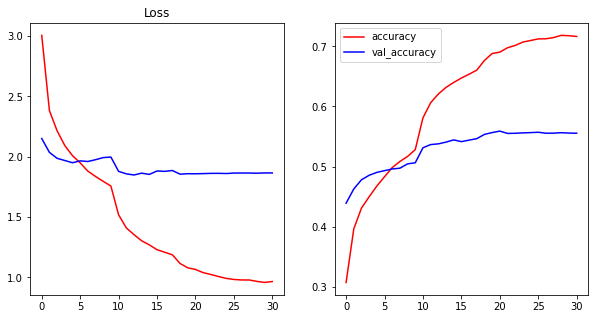

In [34]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], 'r-', label='loss')
plt.plot(hist.history['val_loss'], 'b-', label='val_loss')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], 'r-', label='accuracy')
plt.plot(hist.history['val_accuracy'], 'b-', label='val_accuracy')
plt.legend()
plt.show()


Epoch 1/200
391/391 [==============================] - 24s 62ms/step - loss: 1.0358 - accuracy: 0.6973 - val_loss: 1.8547 - val_accuracy: 0.5585
Epoch 2/200
391/391 [==============================] - 24s 61ms/step - loss: 1.0158 - accuracy: 0.7043 - val_loss: 1.8542 - val_accuracy: 0.5580
Epoch 3/200
391/391 [==============================] - 24s 61ms/step - loss: 1.0270 - accuracy: 0.7017 - val_loss: 1.8514 - val_accuracy: 0.5596
Epoch 4/200
391/391 [==============================] - 24s 62ms/step - loss: 1.0180 - accuracy: 0.7037 - val_loss: 1.8514 - val_accuracy: 0.5587
Epoch 5/200
391/391 [==============================] - 24s 61ms/step - loss: 1.0165 - accuracy: 0.7041 - val_loss: 1.8510 - val_accuracy: 0.5588
Epoch 6/200
391/391 [==============================] - 24s 62ms/step - loss: 1.0111 - accuracy: 0.7062 - val_loss: 1.8510 - val_accuracy: 0.5589
Epoch 7/200
391/391 [==============================] - 24s 61ms/step - loss: 1.0134 - accuracy: 0.7058 - val_loss: 1.8501 - val_ac

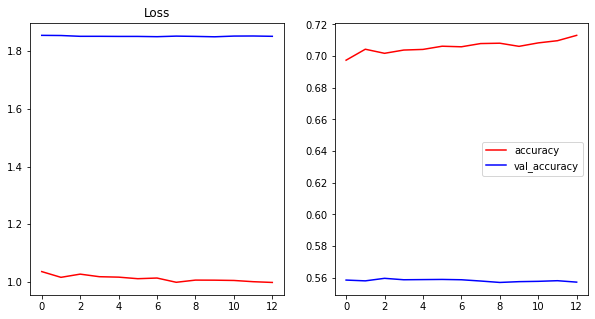

In [35]:
# Final tune
model.trainable = True

hist = model.fit(train_ds, batch_size=nb_batch, epochs=nb_epochs,
                 verbose=1, validation_data=test_ds,
                 shuffle=True,
                 callbacks=[checkpointer, callback, lr_reducer])
                 
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], 'r-', label='loss')
plt.plot(hist.history['val_loss'], 'b-', label='val_loss')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], 'r-', label='accuracy')
plt.plot(hist.history['val_accuracy'], 'b-', label='val_accuracy')
plt.legend()
plt.show()



In [36]:
# 학습 결과 테스트를 이미지화 함수
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
               color=color)

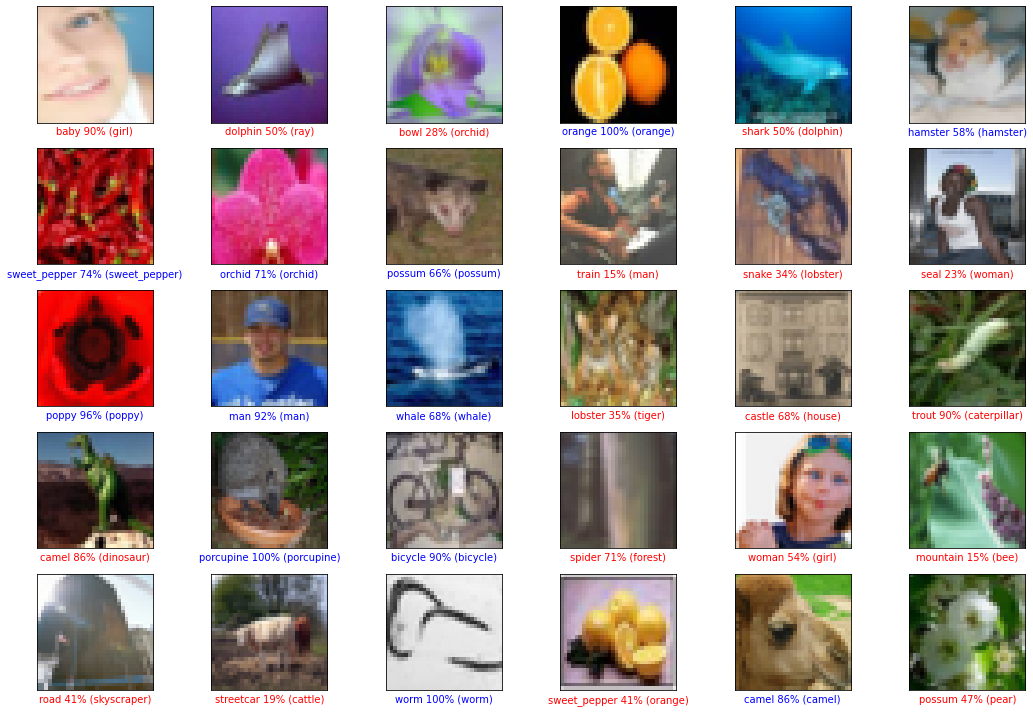

In [37]:
# 예측 결과 이미지화
test_iter = iter(test_ds.shuffle(nb_batch))
num_rows = 5
num_cols = 6
num_images = num_rows*num_cols
plt.figure(figsize=(15, 10), facecolor='white')

test_img_list, test_label_list = next(test_iter)

# Test 이미지 예측
predictions = model.predict(test_img_list)

for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    plot_image(i, predictions[i], test_label_list, test_img_list)
plt.tight_layout()
plt.show()
